<a href="https://colab.research.google.com/github/hrumst/ML/blob/master/my_object_detection_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive') 
!ls -la "/content/gdrive/My Drive/colab_data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
total 8
drwx------ 2 root root 4096 Sep 19 05:26 Mask_RCNN-master
drwx------ 2 root root 4096 Sep 15 19:16 models


In [2]:
%cd "/content/gdrive/My Drive/colab_data/models/research"

/content/gdrive/My Drive/colab_data/models/research


In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [33]:
!pwd

/content/gdrive/My Drive/colab_data/models/research


In [38]:
!rm -rf /content/input \
&& mkdir /content/input \
&& unzip "../../../competition_7/brand-logo-detection-dataset.zip" -d /content/input

Archive:  ../../../competition_7/brand-logo-detection-dataset.zip
   creating: /content/input/brand-logo-detection-dataset/
   creating: /content/input/brand-logo-detection-dataset/trainval_jpg/
  inflating: /content/input/brand-logo-detection-dataset/trainval_jpg/4652863706.jpg  
   creating: /content/input/__MACOSX/
   creating: /content/input/__MACOSX/brand-logo-detection-dataset/
   creating: /content/input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/
  inflating: /content/input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._4652863706.jpg  
  inflating: /content/input/brand-logo-detection-dataset/trainval_jpg/4328758763.jpg  
  inflating: /content/input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._4328758763.jpg  
  inflating: /content/input/brand-logo-detection-dataset/trainval_jpg/320927855.jpg  
  inflating: /content/input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._320927855.jpg  
  inflating: /content/input/brand-logo-detection-dataset/trainval_j

In [0]:
import sys
sys.path.insert(0, '/content/gdrive/My Drive/colab_data/models/research')
sys.path.insert(0, '/content/gdrive/My Drive/colab_data/models/research/slim')

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


In [0]:
# from colab.utils import label_map_util
from object_detection.utils import label_map_util, dataset_util
from object_detection.utils import visualization_utils as vis_util

# OWN DATAST

In [40]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
!tar -xzf ssd_mobilenet_v1_coco_2018_01_28.tar.gz

--2019-09-21 09:30:15--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.76.128, 2a00:1450:400c:c00::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.76.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76541073 (73M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz’

ssd_mobilenet_v1_co 100%[===================>]  73.00M  32.9MB/s    in 2.2s    

2019-09-21 09:30:17 (32.9 MB/s) - ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz’ saved [76541073/76541073]



In [65]:
import pandas as pd

BASE_DATA_DIR = 'input/brand-logo-detection-dataset/'
df = pd.read_csv(BASE_DATA_DIR + 'trainval_bboxes.txt', header=None)
df.columns = ['image_id','brand_name','x', 'y', 'width', 'height']

brand_list = df['brand_name'].unique()
brand_map = dict()
for (i, brand) in enumerate(brand_list):
    brand_map[brand] = i
df.head()

,image_id,brand_name,x,y,width,height
0,2325670467.jpg,google,51,198,892,342
1,2359495755.jpg,google,73,228,948,327
2,2727802511.jpg,google,68,72,854,311
3,321106127.jpg,google,461,354,519,203
4,343855903.jpg,google,176,104,686,413


In [0]:
def split_datasets(dataset, val=.1):
    val_dataset = []
    train_dataset = []
    for item in dataset:
        if np.random.rand() <= val:
            val_dataset.append(item)
        else:
            train_dataset.append(item)
    return (train_dataset, val_dataset)

def create_tf_example(image_id):
    image_data = df[df['image_id'] == image_id]
    img_fpath = os.path.join('/content/gdrive/My Drive/colab_data/models/research/input/brand-logo-detection-dataset/trainval_jpg', image_id)
    if os.path.isfile(img_fpath) == False:
        return
    img = Image.open(img_fpath)
    height = img.size[1]
    width = img.size[0]
    filename = str.encode(image_id)
    with open(img_fpath, mode='rb') as f:
        encoded_image_data = f.read()
    image_format = b'jpeg'

    # List of normalized left x coordinates in bounding box (1 per box)
    xmins = [] 
    # List of normalized right x coordinates in bounding box # (1 per box)
    xmaxs = [] 
    # List of normalized top y coordinates in bounding box (1 per box)
    ymins = [] 
    # List of normalized bottom y coordinates in bounding box # (1 per box)
    ymaxs = [] 
    # List of string class name of bounding box (1 per box)
    classes_text = []
    # List of integer class id of bounding box (1 per box)
    classes = []

    for (i, row) in image_data.iterrows():
        xmins.append(row['x'])
        ymins.append(row['y'])
        xmaxs.append(row['x'] + row['width'])
        ymaxs.append(row['y'] + row['height'])
        classes_text.append(bytes(row['brand_name'], encoding = 'utf-8'))
        classes.append(brand_map[row['brand_name']] + 1)

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [50]:
train_images, val_images = split_datasets(df['image_id'].unique())
(len(train_images), len(val_images))

(1150, 130)

In [0]:
train_writer = tf.python_io.TFRecordWriter('/content/gdrive/My Drive/colab_data/models/research/input/train_data.record')
for image_id in train_images:
    tf_example = create_tf_example(image_id)
    if tf_example is None:
        continue
    train_writer.write(tf_example.SerializeToString())

val_writer = tf.python_io.TFRecordWriter('/content/gdrive/My Drive/colab_data/models/research/input/val_data.record')
for image_id in val_images:
    tf_example = create_tf_example(image_id)
    if tf_example is None:
        continue
    val_writer.write(tf_example.SerializeToString())

In [75]:
!pwd

/content/gdrive/My Drive/colab_data/models/research


In [0]:
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim ; python object_detection/model_main.py \
    --pipeline_config_path=input/pipeline.config \
    --model_dir=my_output \
    --num_train_steps=1000 \
    --alsologtostderr

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W0921 11:36:33.531584 139988175910784 deprecation_wrapper.py:119] From /content/gdrive/My Drive/colab_data/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0921 11:36:33.538036 139988175910784 deprecation_wrapper.py:119] From /content/gdrive/My Drive/colab_data/models/research/object_detection/model_lib.py:616: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0921 11:36:33.538200 139988175910784 model_lib.py:617] Forced number of epochs for all eval validations to be 1.

W0921 11:36:33.538333

In [0]:
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim ; python object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=object_detection/my_data/pipeline.config \
    --trained_checkpoint_prefix=object_detection/my_data/output/model.ckpt-1000 \
    --output_directory=object_detection/my_data/output/frozen/

# Model RUN

## Env setup

In [0]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [0]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection', 'data', 'mscoco_label_map.pbtxt')

## Download Model

In [0]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [11]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

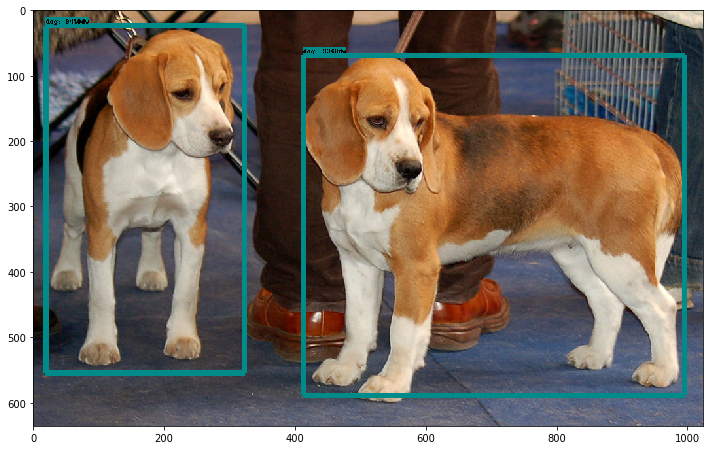

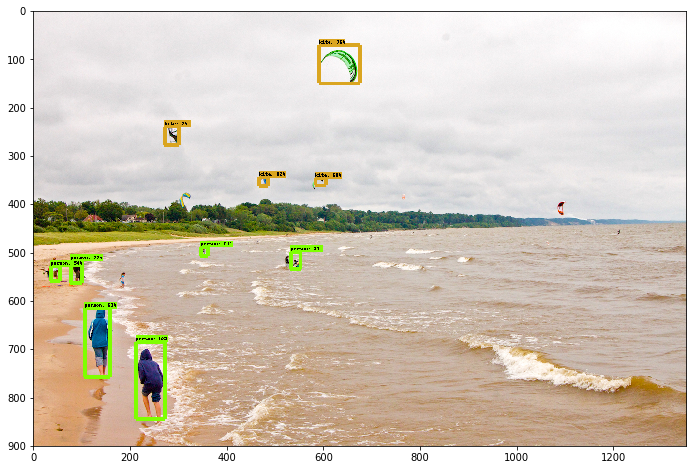

In [31]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

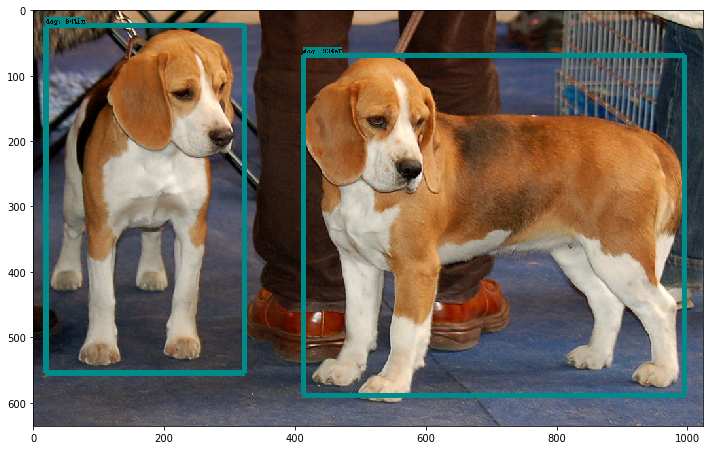

In [30]:
image = Image.open(PATH_TO_TEST_IMAGES_DIR + '/image1.jpg')
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)
plt.pause(.01)

In [17]:
output_dict.keys()

dict_keys(['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes'])

In [18]:
output_dict['num_detections']

100

In [19]:
output_dict['detection_boxes'].shape

(100, 4)

In [20]:
output_dict['detection_boxes'][1]

array([0.10951501, 0.4028356 , 0.9246461 , 0.97304785], dtype=float32)

In [21]:
output_dict['detection_scores']

array([0.940691  , 0.93450284, 0.23088074, 0.22518921, 0.17249939,
       0.13962042, 0.13212013, 0.0997574 , 0.08992732, 0.08888885,
       0.08091828, 0.07895195, 0.07818308, 0.07565781, 0.07331276,
       0.07074901, 0.06597453, 0.06404528, 0.06387982, 0.06381166,
       0.06380174, 0.06050125, 0.05898514, 0.05898359, 0.05761391,
       0.05641383, 0.05638787, 0.05500016, 0.0549573 , 0.05426386,
       0.05425414, 0.05409572, 0.05335921, 0.05279228, 0.05228499,
       0.05219465, 0.05164066, 0.05066013, 0.05030194, 0.04837736,
       0.04822722, 0.04720658, 0.04673687, 0.04671788, 0.04644233,
       0.04614899, 0.04420185, 0.0428651 , 0.04251248, 0.04174343,
       0.04166573, 0.04137334, 0.04096091, 0.04053533, 0.0399096 ,
       0.03988704, 0.03984377, 0.0393098 , 0.03923887, 0.03877974,
       0.03877515, 0.03852978, 0.03816217, 0.03815901, 0.03742453,
       0.0368987 , 0.03677586, 0.0367116 , 0.03654775, 0.03635326,
       0.03612369, 0.03610817, 0.0360195 , 0.03586456, 0.03582

In [22]:
output_dict['detection_classes']

array([18, 18, 18, 18, 18, 33,  1, 63, 18, 21,  3, 18,  1, 18, 21, 18, 62,
       18, 18, 62,  1, 62, 18,  3,  1, 21,  1,  1,  1,  1,  1, 18,  1,  1,
        1,  1, 62,  1,  1,  1,  1,  1, 62, 18,  1, 63,  1,  1, 84,  1,  1,
       18,  1,  1, 62, 21, 57, 18, 18, 62, 18,  1,  1,  1,  1,  1,  1,  1,
       18, 62,  1, 88, 47,  1, 47, 62, 84,  1, 18,  1,  1,  1,  1, 84, 18,
       62, 18, 21,  1, 62, 62,  1, 18, 21,  1, 18, 47,  1,  1, 47])